## Advanced Lane Finding 

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


### Camera Calibration

####  camera matrix, distortion coefficients and example of a distortion corrected calibration image.
The images in this project needs set the chessboard size to 9x6 instead of 8x6. 
some of these images do not appear because the specified number of chessboard corners were not found(calibration1.jpg,calibration4.jpg,calibration5.jpg)

* "object points": (x, y, z) coordinates of the chessboard corners.
Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it 
* `imgpoints` : 
This will be appended with the (x, y) pixel position of each of the corners in the image plane with each chessboard detection.  
These two are `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function. The `cv2.undistort()` function provides distortion correction to the test image.

In [22]:
import pickle
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

CAMERA_CAL_PATH = './camera_cal'
EXAMPLES_PATH = './examples'
OUTPUT_PATH = './output_images'
TEST_PATH = './test_images'

PROJECT_VIDEO_PATH = './project_video.mp4'
CHALLENGE_VIDEO_PATH = './challenge_video.mp4'

# prepare object points
nx = 9 #the number of inside corners in x
ny = 6 #the number of inside corners in y

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane.

def get_filename_without_extension(path):
    filename = os.path.basename(path)
    dot_idx = filename.index('.')
    return filename[:dot_idx]

def calibration(images, nx, ny):
    # Arrays to store object points and image points from all the images.
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    img0 = cv2.imread('./camera_cal/calibration1.jpg')
    img_size = (img0.shape[1], img0.shape[0])

    # Step through the list and search for chessboard corners
    for i, fname in enumerate(images):
        img = cv2.imread(fname) ## cv2 read a image in BGR 
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)    
            # Draw and display the corners
    # Read in the saved camera matrix and distortion coefficients
    # These are the arrays you calculated using cv2.calibrateCamera()
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    return  ret, mtx, dist

calibration_img_paths = glob.glob(os.path.join(CAMERA_CAL_PATH, '*.jpg'))
calibration_params = calibration(calibration_img_paths, 9, 6)
#.....ret, mtx, dist

# Read in the saved objpoints and imgpoints
dist_pickle = {}
#objpoints = dist_pickle["objpoints"]
#imgpoints = dist_pickle["imgpoints"]
dist_pickle["mtx"] = calibration_params[1]
dist_pickle["dist"] = calibration_params[2]
pickle.dump( dist_pickle, open("calibration.p", "wb" ))

#### Calibartion example.
did generated all calibration examples from previous Note(Project2.ipynb) from first submission but I deleted here to save sapce. In the "readme.md" there are examples as well as output images from output_images folder 
.

In [23]:
def cal_undistort(img, objpoints, imgpoints):
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    #undist = np.copy(img)  # Delete this line
    return undist

def undistort(img):
    ret, mtx, dist = calibration_params
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

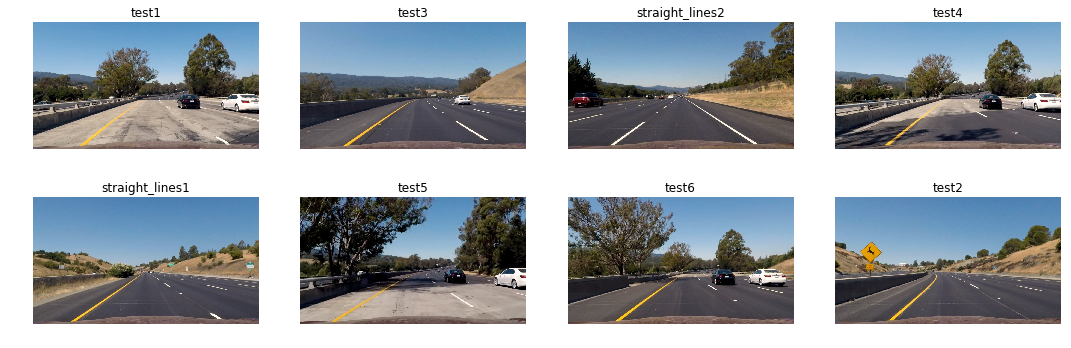

In [24]:
test_img_paths = glob.glob(os.path.join(TEST_PATH, '*.jpg'))
undist_images = []
fig, axs = plt.subplots(2,4, figsize=(15, 5))
fig.tight_layout()
axs = axs.ravel()
for idx, test_img_path in enumerate(test_img_paths):
    test_img = mpimg.imread(test_img_path)
    fname = get_filename_without_extension(test_img_path)
    undist = undistort(test_img)  
    axs[idx].axis('off')
    axs[idx].imshow(undist)
    axs[idx].set_title(fname)
    undist_images.append(undist)


#### color transforms
combination of color and gradient thresholds to generate a binary image

In [25]:
## RGB Color Space
def rgb_select(image, thresh=(0, 255), ch=0):
    rgb = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    Ch = rgb[:,:,ch]    
    binary_output = np.zeros_like(Ch)
    binary_output[(Ch > thresh[0]) & (Ch <= thresh[1])] = 1
    return binary_output

### HLS color space
def hls_select(image, thresh=(0, 255), ch=0):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    Ch = hls[:,:,ch]    
    binary_output = np.zeros_like(Ch)
    binary_output[(Ch > thresh[0]) & (Ch <= thresh[1])] = 1
    return binary_output
## HSV Color Space
def hsv_select(image, thresh=(0, 255), ch=0):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    Ch = hsv[:,:,ch]    
    binary_output = np.zeros_like(Ch)
    binary_output[(Ch > thresh[0]) & (Ch <= thresh[1])] = 1
    return binary_output
### LUV color 
def luv_select(image, thresh=(0, 255), ch=0):
    luv = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    Ch = luv[:,:,ch]    
    binary_output = np.zeros_like(Ch)
    binary_output[(Ch > thresh[0]) & (Ch <= thresh[1])] = 1
    return binary_output
### LAB color space
def lab_select(image, thresh=(0, 255), ch=0):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    Ch = lab[:,:,ch]    
    binary_output = np.zeros_like(Ch)
    binary_output[(Ch > thresh[0]) & (Ch <= thresh[1])] = 1
    return binary_output

#### Color Transform
RGB, LUV, LAB, HSV, HLS color transform examples

S-channel of HLS colorspace is good to find the yellow line, and in combination with gradients, through expreriment S channel Threshold (min=100, max=255) in HLS color space works pretty good.

In [26]:
def abs_sobel_thresh(image, orient='x', thresh_min=0, thresh_max=255):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1   
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    mag_sobel = np.sqrt(sobelx**2+sobely**2)
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return mag_binary

def dir_threshold(image, sobel_kernel=3, dir_thresh=(0, np.pi/2)):    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize= sobel_kernel))
    abs_sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize= sobel_kernel)) 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    return dir_binary

Abs_sobel_Y Gradient and Threshold Magnitude can detect line better. A combination of these two threshold magnitude and Directional threshold will be useful.

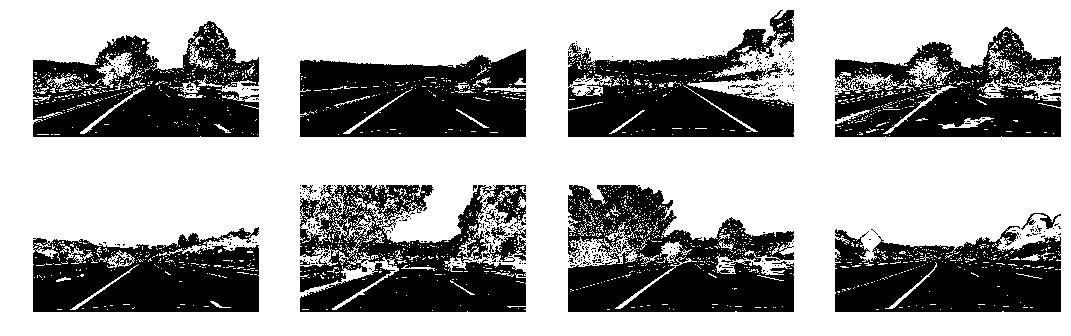

In [27]:
##Color+SobelThreshold combined
def combined(image):
    #gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=50, thresh_max=255)
    mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(50,255))
    dir_binary = dir_threshold(image, sobel_kernel=3, dir_thresh=(0.7,1.3))
    l_binary = lab_select(image, (170,255),0)
    s_binary = hls_select(image, (80,255),2)
    #grad_y_binary = abs_sobel_thresh(image , 'y', (80,255))
    combined = np.zeros_like(dir_binary)
    combined[(grady==1) | (s_binary == 1)  | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

fig, ax = plt.subplots(2,4, figsize=(15, 5))
fig.tight_layout()
ax = ax.ravel()

for idx, test_img_path in enumerate(test_img_paths):
    test_img = mpimg.imread(test_img_path)
    undist = undistort(test_img)
    combinedImg = combined(undist)
    ax[idx].axis('off')
    ax[idx].imshow(combinedImg,  cmap='gray',vmin=0, vmax=1)

In [28]:
#########
# Define a function that takes an image, number of x and y points, 
# camera matrix and distortion coefficients
def warper(img):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[203, 720], 
                      [585, 460], 
                      [695, 460], 
                      [1127, 720]])
    dst = np.float32([[310, 720], 
                  [310, 0], 
                  [980, 0], 
                  [980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

def unwarp(img):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    src = np.float32([[203, 720], 
                      [585, 460], 
                      [695, 460], 
                      [1127, 720]])
    dst = np.float32([[310, 720], 
                  [310, 0], 
                  [980, 0], 
                  [980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
def corners_unwarp(img, nx, ny, mtx, dist):
    # Use the OpenCV undistort() function to remove distortion
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    # Convert undistorted image to grayscale
    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    # Search for the chessboard corners in the grayscaled image 
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    M = None
    warped = np.copy(img) 
    if ret == True:
        # If we found corners, Draw and display the corners
        cv2.drawChessboardCorners(undist, (nx, ny), corners, ret)
        # Choose offset from image corners to plot detected corners # This should be chosen to present the result at the proper aspect ratio # My choice of 100 pixels is not exact, but close enough for our purpose here
        offset = 100 # offset for dst points
        # Grab the image shape
        img_size = (gray.shape[1], gray.shape[0])

        # For source points I'm grabbing the outer four detected corners
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        # For destination points, I'm arbitrarily choosing some points to be
        # a nice fit for displaying our warped result 
        # again, not exact, but close enough for our purposes
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        # Given src and dst points, calculate the perspective transform matrix
        M = cv2.getPerspectiveTransform(src, dst)
        # Warp the image using OpenCV warpPerspective()
        warped = cv2.warpPerspective(undist, M, img_size)

        # Return the resulting image and matrix
    return warped, M

Straight Line is detected pretty clean where as Curved Line needs some work to do. 

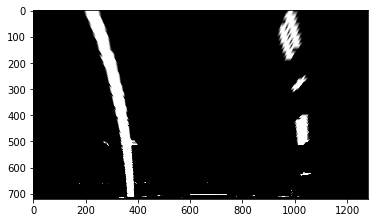

In [30]:
#image = mpimg.imread('./output_images/straight_lines1_undistort.jpg')
def perspective_transform(img): 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[203, 720], 
                      [585, 460], 
                      [695, 460], 
                      [1127, 720]])
    dst = np.float32([[310, 720], 
                  [310, 0], 
                  [980, 0], 
                  [980, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    M_INV = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, M_INV, (warped.shape[1], warped.shape[0]), flags=cv2.INTER_LINEAR)  # DEBUG
    return warped, unwarped, M, M_INV

img = mpimg.imread(test_img_paths[0])
img = cv2.undistort(img, mtx, dist, None, mtx)
img = combined(undist)
binary_warped, binary_unwarped, M, M_inv = perspective_transform(img)
plt.imshow(binary_warped,  cmap='gray',vmin=0, vmax=1)

plt.savefig('./output_images/all_combined_warped.jpg')

[1st Peak] min pixel: 350, max pixel: 369
[2nd Peak] min pixel: 1017, max pixel: 1045


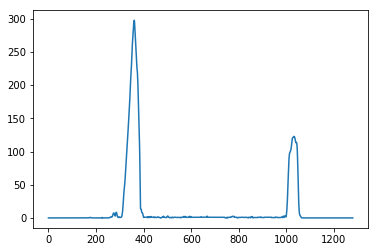

In [32]:
def getHist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]
    #  Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

# Create histogram of image binary activations
histogram = getHist(binary_warped)
# Visualize the resulting histogram
plt.plot(histogram)

peak1,peak2 =[], []
for i in range(len(histogram)//2):
    if(histogram[i]>max(histogram)*0.8):
        peak1.append(i)
print("[1st Peak] min pixel: "+str(min(peak1))+ ", max pixel: "+str(max(peak1)))
for i in range(len(histogram)//2,len(histogram)):
    if(histogram[i]>100):
        peak2.append(i)
print("[2nd Peak] min pixel: "+str(min(peak2))+ ", max pixel: "+str(max(peak2)))

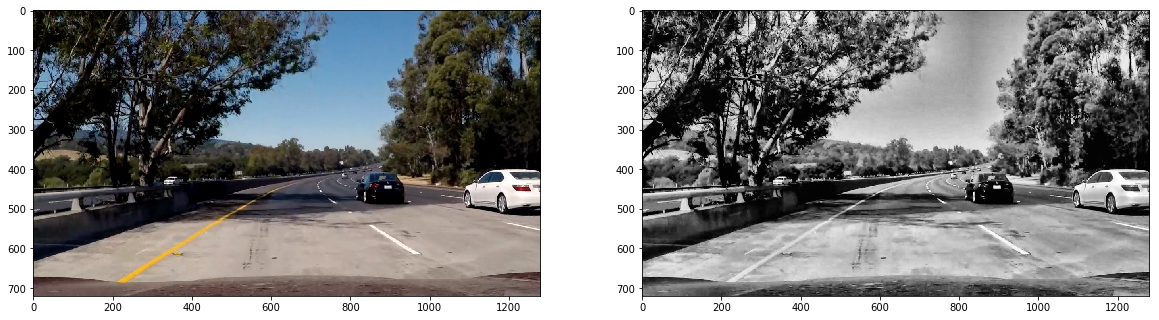

In [33]:
# create a CLAHE object
def applyClahe(image_path):
        bgr = cv2.imread(image_path)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        lab_planes = cv2.split(lab)
        #bottom_half = img[img.shape[0]//2:,:]
        clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(10,10))
        result = clahe.apply(lab_planes[0])
        #lab = cv2.merge(lab_planes)       
        #bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
        return result
img5 = mpimg.imread('./test_images/test5.jpg')
gray5 = cv2.cvtColor(img5, cv2.COLOR_BGR2GRAY) 
#img5_0= cv2.imread('./test_images/test5.jpg',0)
#clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
#cl1 = clahe.apply(img5_0)
cl1=applyClahe('./test_images/test5.jpg')
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title = "Source Image"
ax1.imshow(img5)
ax2.set_title = "CLahe Image"
ax2.imshow(cl1, cmap='gray')

plt.savefig('./output_images/test5_clahe.jpg')

#### 2nd order polynomial 

(720, 0)

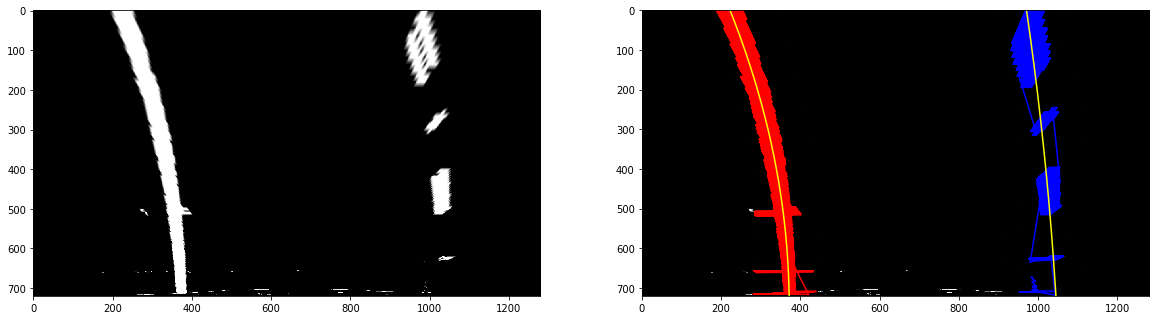

In [40]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0, 255, 0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0, 255, 0), 5) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    visualization_data = (rectangle_data, histogram)

    return leftx, lefty, rightx, righty, out_img, visualization_data

def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, visualization_data = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    rectangles = visualization_data[0]
    histogram = visualization_data[1]
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    for rect in rectangles:
    # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    
    return  left_fitx, right_fitx, out_img
    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

# # Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )

leftx, lefty, rightx, righty, out_img, visualization_data = find_lane_pixels(binary_warped)

rectangles = visualization_data[0]
# Draw the windows on the visualization image
for rect in rectangles:
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(binary_warped, cmap='gray')
ax2.imshow(out_img)
out_img[lefty, leftx] = [255, 0, 0]
out_img[righty, rightx] = [0, 0, 255]

ax2.plot(leftx, lefty, color='red')
ax2.plot(rightx, righty,color='blue')
# Plots the left and right polynomials on the lane lines
left_fitx, right_fitx,out_img2 = fit_polynomial(binary_warped)
ax2.plot(left_fitx, ploty, color='yellow')
ax2.plot(right_fitx, ploty, color='yellow')

            #cv2.imwrite(outfile, img)
plt.savefig('./output_images/test5_poly.jpg')

plt.xlim(0, 1280)
plt.ylim(720, 0)

### Pipeline (single images)
#### map_lane()

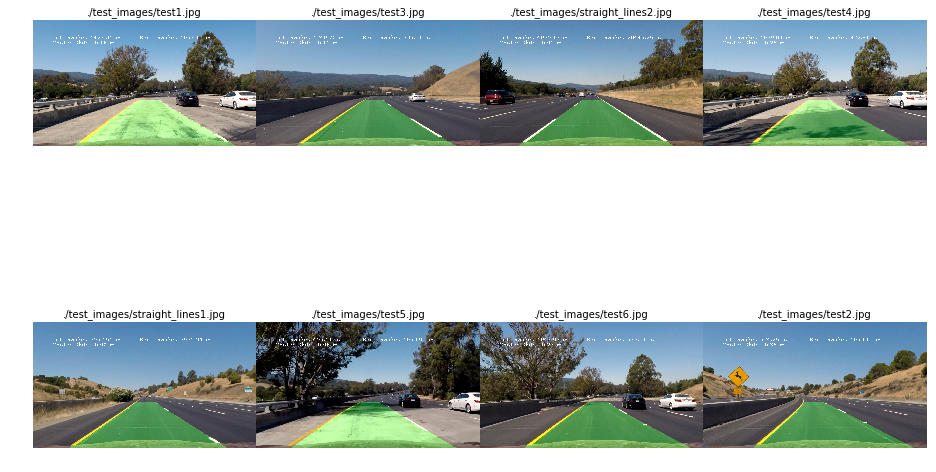

In [41]:
def generate_data(ym_per_pix, xm_per_pix):
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y

    # Fit a second order polynomial to pixel positions in each fake lane line
    ##### TO-DO: Fit new polynomials to x,y in world space #####
    ##### Utilize `ym_per_pix` & `xm_per_pix` here #####
    #left_fit_cr = np.polyfit(ploty, leftx, 2)
    #right_fit_cr = np.polyfit(ploty, rightx, 2)
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)

    return ploty, left_fit_cr, right_fit_cr

def measure_curvature(left_fit, right_fit, warped_combination):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Start by generating our fake example data
    # Make sure to feed in your real data instead in your project!
    #ploty, left_fit_cr, right_fit_cr = generate_data(ym_per_pix, xm_per_pix)
    
    ploty = np.linspace(0, warped_combination.shape[0]-1, warped_combination.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### Implement the calculation of R_curve (radius of curvature) #####
    #left_curverad = 0  ## Implement the calculation of the left line here
    #right_curverad = 0  ## Implement the calculation of the right line here
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    average_curverad = (left_curverad+right_curverad)/2
    '''
    Offset in lane
    '''
    bottom_y = image.shape[0] #image shape = [720,1280]
    left_fit_bottom = left_fit[0]*bottom_y**2 + left_fit[1]*bottom_y + left_fit[2]
    right_fit_bottom = right_fit[0]*bottom_y**2 + right_fit[1]*bottom_y + right_fit[2]

    lane_center = (left_fit_bottom + right_fit_bottom)/2.
    offset_pix = image.shape[1]/2 - lane_center # in pixels, image shape = [720,1280]
    center_dist = offset_pix*xm_per_pix
    return left_curverad, right_curverad, average_curverad, center_dist

# Create an image to draw the lines on
fig, axs = plt.subplots(2,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .02, wspace=.001)
axs = axs.ravel()
image_names = glob.glob(os.path.join('./test_images', '*.jpg'))
for i, fname in enumerate(image_names):
    #image = cv2.imread(fname)
    image = mpimg.imread(fname)
    gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', thresh_min=80, thresh_max=255)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=80, thresh_max=255)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, dir_thresh=(0, 1.2))
    hls_binary = hls_select(image, thresh=(100, 255), ch=2)
    lab_binary = lab_select(image, thresh=(75, 255), ch=2)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((hls_binary == 1) & (lab_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    combine_warped = warper(combined)
    warp_zero = np.zeros_like(combine_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
 
    left_fitx, right_fitx, out_img = fit_polynomial(combine_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, combine_warped.shape[0] )
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
 
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    warped, M, Minv = unwarp(image) 
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist= cal_undistort(image, objpoints, imgpoints)
    leftx, lefty, rightx, righty, result, visualization_data = find_lane_pixels(combine_warped)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Get the radius of curvature and offset
    left_rad, right_rad, average_rad, center_dist = measure_curvature(left_fit, right_fit, combine_warped)
    average_rad_string = "Radius of Curvature: %.2f m" % average_rad
    center_dist = "Center Dist: %.2f m" % center_dist
    left_rad_string =  "Left Radius: %.2f m" % left_rad
    right_rad_string =  "Right Radius: %.2f m" % right_rad
    cv2.putText(result,left_rad_string , (110, 110), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
    cv2.putText(result,right_rad_string , (610, 110), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
    #cv2.putText(result,average_rad_string , (110, 110), cv2.FONT_HERSHEY_PLAIN, 4, (255,255,255), thickness=2)
    cv2.putText(result, center_dist, (110, 140), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
 
    axs[i].axis('off')
    axs[i].imshow(result)
    axs[i].set_title(fname, fontsize=10)
    mpimg.imsave('./output_images/fill_lane_'+str(i)+'.jpg', result)
plt.savefig('./output_images/fill_lane_all.jpg')

In [42]:
def combined_gradient(image):
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
        # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    #img_unwarp, M, Minv = unwarp(img_undistort, src, dst)
    # HLS L-channel Threshold (using default parameters)
    #img_LThresh,s_binary = hls_threshold(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    #img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    #combined = np.zeros_like(img_BThresh)
    #combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    #return combined, Minv

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x',thresh_min=20, thresh_max=110)
    grady = abs_sobel_thresh(image, orient='y', thresh_min=20, thresh_max=110)
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(80, 255))
    dir_binary = dir_threshold(image, sobel_kernel=15, dir_thresh=(0.2, 0.4))
    #l_binary, s_binary = hls_threshold(image)
    hls_binary = hls_select(image, thresh=(100, 255), ch=2)
    lab_binary = lab_select(image, thresh=(75, 255), ch=2)

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((hls_binary == 1) & (lab_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary != 1)) & ((s_binary == 1) & (luv_binary == 1) & (l_binary != 1))] = 1
    #combined[ ((gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | ((s_binary == 1) | (l_binary == 1))) ] = 1
    return combined
def process_image(img):
    undist = cal_undistort(img, objpoints, imgpoints)
    combined_gradient_binary = combined_gradient(undist)
    
    binary_warped = warper(combined_gradient_binary)
    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 60
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 60
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Get the radius of curvature and offset
    left_rad, right_rad, average_rad, offset_m = measure_curvature(left_fit, right_fit, combined_gradient_binary)
    left_rad_string =  "Left Radius: %.2f m" % left_rad
    right_rad_string =  "Right Radius: %.2f m" % right_rad
    #average_rad_string = "Radius of Curvature: %.2f m" % average_rad
    offset_string = "Center Offset: %.2f m" % offset_m
    
    cv2.putText(result,left_rad_string , (110, 110), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
    cv2.putText(result,right_rad_string , (610, 110), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
    cv2.putText(result, offset_string, (110, 140), cv2.FONT_HERSHEY_PLAIN, 2, (255,255,255), thickness=2)
    
    return result

In [43]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        #number of detected pixels
        self.px_count = None
    
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:

                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)
    

In [45]:
l_line = Line()
r_line = Line()

video_output = 'output_videos/project_video_result.mp4'
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_result.mp4
[MoviePy] Writing video output_videos/project_video_result.mp4


100%|█████████▉| 1260/1261 [26:29<00:01,  1.28s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_result.mp4 

CPU times: user 24min 15s, sys: 3.56 s, total: 24min 18s
Wall time: 26min 32s


---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)



In [46]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))

---
### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  

In [19]:
l_line = Line()
r_line = Line()

chall_output = 'output_videos/project_video_challenge.mp4'
clip2 = VideoFileClip("challenge_video.mp4")

chall_clip = clip2.fl_image(process_image) #NOTE: this function expects color images!!

%time chall_clip.write_videofile(chall_output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_challenge.mp4
[MoviePy] Writing video output_videos/project_video_challenge.mp4


100%|██████████| 485/485 [10:05<00:00,  1.30s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_challenge.mp4 

CPU times: user 9min 7s, sys: 11.5 s, total: 9min 18s
Wall time: 10min 8s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(chall_output))